In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from utils.model import load_sam
from classes.SAMClass import SAMWrapper, SAMInferer

from utils.base_classes import Points, Boxes2d
import utils.prompt as prUt
import utils.analysis as anUt
from utils.image import read_im_gt

In [9]:
import pickle
with open('/home/t722s/Desktop/test/input_point.pkl', 'rb') as f:
    input_point_sam = pickle.load(f)

In [10]:
# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

sam_model = load_sam(checkpoint_path, device)
sam_wrapper = SAMWrapper(sam_model, device)
sam_inferer = SAMInferer(sam_wrapper, device)

In [11]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[:,:,0]
image_3d = np.zeros((128, image.shape[0], image.shape[1]))
image_3d[0] = image

In [12]:
# TEST POINTS

input_point = np.array([[500, 375]])
input_label = np.array([1])
input_point_3d = np.array([[0, 375, 500]])
prompt = Points({'coords': input_point_3d,'labels': input_label})

segmentation = sam_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


In [22]:
# TEST BOXES

prompt = Boxes2d({0: [425, 600, 700, 875]})

segmentation = sam_inferer.predict(image_3d, prompt)

Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


In [23]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


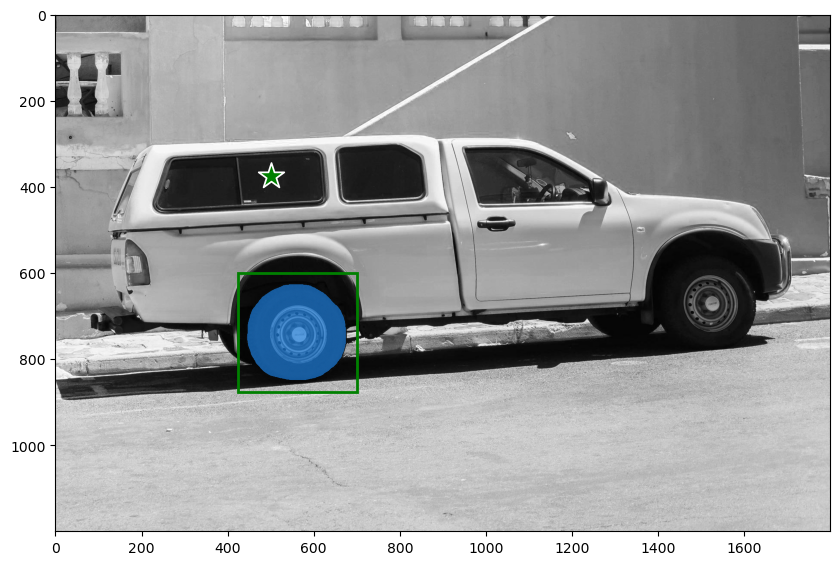

In [26]:
seg_2d = segmentation[0]
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
show_points(input_point, input_label, plt.gca())
input_box = [425,600,700,875]
show_box(input_box, plt.gca())
show_mask(seg_2d, plt.gca())
plt.axis('on')
plt.show()  
